### 스팸메일 분류

In [1]:
import pandas as pd

df = pd.read_csv('c:/workspace3/data/spam.csv',encoding='latin1')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
# ham => 0, spam => 1 로 바꾸어 저장

df['v1'] = df['v1'].replace(['ham','spam'],[0,1])
df[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

v1
0    4825
1     747
Name: count, dtype: int64


<Axes: xlabel='v1'>

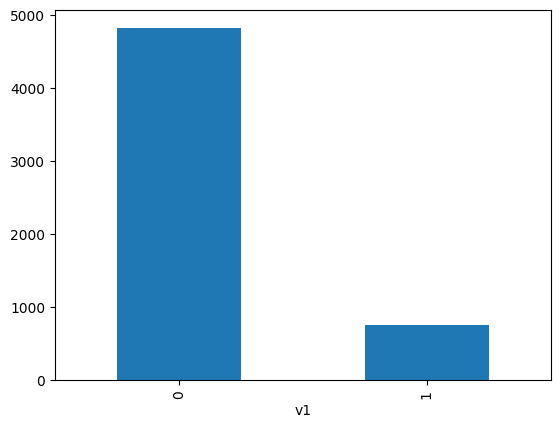

In [4]:
print(df['v1'].value_counts())

df['v1'].value_counts().plot(kind='bar')

In [5]:
X=df[['v2']] #독립변수
y=df['v1'] #종속변수

print(X[:3])
print(y[:3])

                                                  v2
0  Go until jurong point, crazy.. Available only ...
1                      Ok lar... Joking wif u oni...
2  Free entry in 2 a wkly comp to win FA Cup fina...
0    0
1    0
2    1
Name: v1, dtype: int64


v1
0    747
1    747
Name: count, dtype: int64


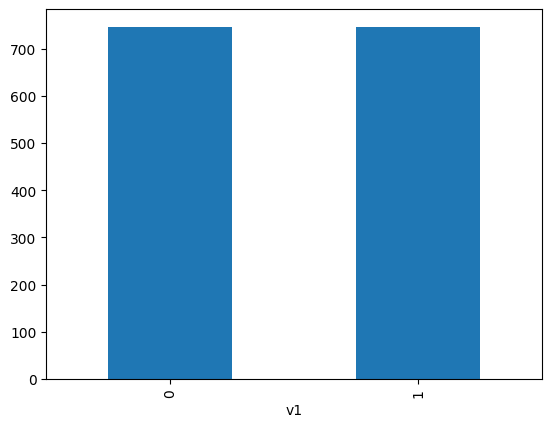

In [6]:
#언더샘플링

from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=['v2'] )
y_samp = pd.DataFrame(data=y_sample,columns=['v1'])
df_samp=pd.concat([X_samp,y_samp],axis=1)
print(df_samp['v1'].value_counts())
df_samp['v1'].value_counts().plot(kind='bar')

X = df_samp['v2']
y = df_samp['v1']

In [7]:
from keras.preprocessing.text import Tokenizer

#단어 집합을 만들고 단어에 고유한 숫자 인덱스를 부여
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

#텍스트를 시퀀스로 변환(단어의 인덱스로만 구성된 새로운 리스트)
sequences = tokenizer.texts_to_sequences(X)

print(sequences[:5])

[[1486, 49, 801, 1487, 18, 336, 87, 26, 2274, 45, 27, 173], [1148, 14, 4, 25, 613], [174, 149, 4, 2, 189, 5, 105, 17, 614, 613], [946, 88, 38, 399, 702, 1, 2275, 1488, 130, 2276, 26, 1489, 242, 45, 702, 1, 2277, 2278, 24, 46, 1149], [7, 291, 1490, 802, 553, 53, 316, 26, 803, 703, 25, 63, 47, 217, 1491, 13, 434, 337, 97]]


In [8]:
#단어와 인덱스 목록

word_to_index = tokenizer.word_index

for idx,word in enumerate(word_to_index):
    print(idx+1,word,end=',')
    if idx>8:
        break

1 to,2 you,3 a,4 call,5 i,6 the,7 u,8 your,9 for,10 is,

메일의 최대 길이 : 77
19.846050870147256


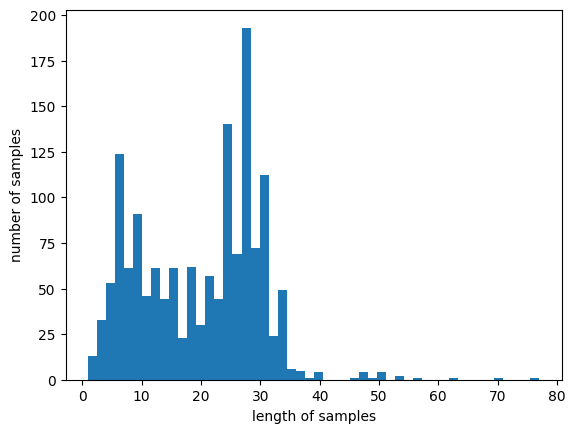

In [9]:
import matplotlib.pyplot as plt

X_data = sequences

print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print(sum(map(len, X_data))/len(X_data)) #메일의 평균 길이

plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples') # 길이
plt.ylabel('number of samples') # 샘플수
plt.show()

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#최대 사이즈에 맞추어 빈칸에 0으로 채움
data = pad_sequences(X_data, maxlen = 77)

print("학습용 데이터의 크기(shape): ", data.shape)
print(data[:1])

학습용 데이터의 크기(shape):  (1494, 77)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1486   49  801 1487   18
   336   87   26 2274   45   27  173]]


In [11]:
#학습용:검증용 8:2로 구분

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y, random_state=10)

In [12]:
from keras.layers import Embedding, Dense, LSTM, SimpleRNN
from keras.models import Sequential

model = Sequential()

# Embedding(입력사이즈,출력사이즈)
model.add(Embedding(len(word_to_index)+1, 32))
model.add(SimpleRNN(32)) # output size 32
#model.add(LSTM(32)) # Long Short-Term Memory
model.add(Dense(1, activation='sigmoid'))
#                              이진분류
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 5s 151ms/step - loss: 0.5252 - accuracy: 0.7803 - val_loss: 0.5519 - val_accuracy: 0.7573
Epoch 2/10
15/15 [==============================] - 2s 129ms/step - loss: 0.3359 - accuracy: 0.8870 - val_loss: 0.3002 - val_accuracy: 0.8996
Epoch 3/10
15/15 [==============================] - 2s 130ms/step - loss: 0.2059 - accuracy: 0.9467 - val_loss: 0.2331 - val_accuracy: 0.9289
Epoch 4/10
15/15 [==============================] - 2s 143ms/step - loss: 0.1542 - accuracy: 0.9582 - val_loss: 0.1597 - val_accuracy: 0.9623
Epoch 5/10
15/15 [==============================] - 2s 135ms/step - loss: 0.1112 - accuracy: 0.9665 - val_loss: 0.1392 - val_accuracy: 0.9498
Epoch 6/10
15/15 [==============================] - 2s 138ms/step - loss: 0.0721 - accuracy: 0.9854 - val_loss: 0.1317 - val_accuracy: 0.9665
Epoch 7/10
15/15 [==============================] - 2s 139ms/step - loss: 0.0495 - accuracy: 0.9937 - val_loss: 0.1230 - val_accuracy: 0.9665
Epoch 

In [14]:
model.evaluate(X_test, y_test.values, verbose=0)
#[손실, 정확도]

[0.12090029567480087, 0.9598662257194519]

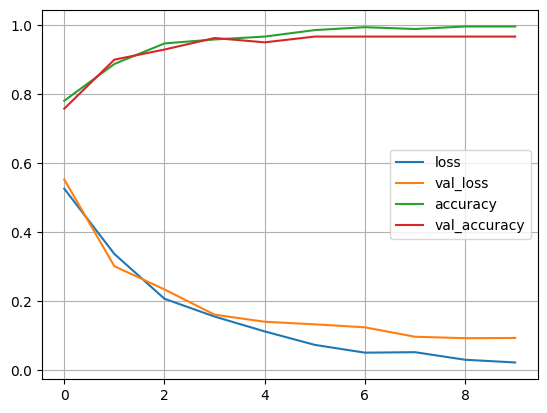

In [15]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()

In [16]:
model.predict(X_test[:3])

1/1 [==============================] - 0s 156ms/step


array([[0.98919964],
       [0.0185055 ],
       [0.9917945 ]], dtype=float32)